# Digital Twin for Remote/Hybrid Productivity — Three Models

Dataset: Kaggle CSV: _Remote Work Productivity_.

- **Target**: `productivity_label = 1` if `Productivity_Score >= 60`, else `0`
- **Features**: `Hours_Worked_Per_Week`, `Well_Being_Score`, `is_remote`
- **Models**: Logistic Regression (baseline), Random Forest (main), Gradient Boosting (extra)
- **Evaluation**: Accuracy, Precision, Recall, F1, Confusion Matrix
- **Digital Twin**: What-if A (−10% hours), What-if B (+10 well-being)
                    What-if C (low WB & high hours subgroup), What-if D(borderline mode swap)

* Scenario A: Reduce hours by 10% for all employees

* Scenario B: Increase well-being score by +10 (capped at 100) for all employees

* Scenario C: Joint intervention for subgroup with low well-being (<50) and high hours (>45)

* Scenario D: Mode swap (remote ↔ office) for borderline prediction cases (p ≈ 0.5)

## Step 1 — Import Libraries

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(42)

## Step 2 — Load Dataset

In [149]:
df = pd.read_csv("remote_work_productivity.csv")
df.head()

,Employee_ID,Employment_Type,Hours_Worked_Per_Week,Productivity_Score,Well_Being_Score
0,1,Remote,29,75,78
1,2,In-Office,45,49,47
2,3,Remote,34,74,89
3,4,Remote,25,81,84
4,5,Remote,50,70,74


**Explanation:**  

---


Load the Kaggle CSV directly with one line. `df.head()` previews the first rows to confirm schema.

The dataset used in this project is the **Remote Work Productivity Dataset** from Kaggle.  
It contains information about employees working either remotely or in-office.  
The data combines quantitative measures of workload, productivity, and well-being.

**Columns:**
- **Employee_ID**: Unique identifier for each employee.  
- **Employment_Type**: Categorical feature, either "Remote" or "In-Office".  
- **Hours_Worked_Per_Week**: Numeric feature indicating weekly work hours.  
- **Productivity_Score**: A score (0–100) estimating employee productivity.  
- **Well_Being_Score**: A score (0–100) reflecting employee well-being.  

**Target Variable:**
- We derive a new column `productivity_label`:  
  - `1` if `Productivity_Score >= 60` (productive)  
  - `0` otherwise (less productive).  


## Step 3 — Prepare Features and Labels

In [150]:
# Label: Productive if score >= 60
df['productivity_label'] = (df['Productivity_Score'] >= 60).astype(int)

# Encode remote status
df['is_remote'] = df['Employment_Type'].str.lower().str.contains('remote').astype(int)

# Features and target
X = df[['Hours_Worked_Per_Week', 'Well_Being_Score', 'is_remote']]
y = df['productivity_label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# After splitting
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("Feature columns:", list(X.columns))


Training set size: 750
Test set size: 250
Feature columns: ['Hours_Worked_Per_Week', 'Well_Being_Score', 'is_remote']


## Step 4a — Train Logistic Regression (Baseline)

In [151]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression coefficients:", lr.coef_)
print("First 10 predictions:", y_pred_lr[:10])

Logistic Regression coefficients: [[ 0.01670914 -0.00337527  1.49788198]]
First 10 predictions: [1 1 1 1 1 1 1 1 1 1]


**Explanation:**  
A linear, interpretable baseline. Useful to compare against tree ensembles.

## Step 4b — Train Random Forest (Main Model)

In [152]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest trained with", len(rf.estimators_), "trees")
print("First 10 predictions:", y_pred_rf[:10])


Random Forest trained with 200 trees
First 10 predictions: [0 1 0 1 1 1 1 1 1 1]


**Explanation:**  
Random Forest captures nonlinearity and interactions and provides feature importance.

## Step 4c — Train Gradient Boosting (Extra)

In [153]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting number of stages:", len(gb.estimators_))
print("First 10 predictions:", y_pred_gb[:10])

Gradient Boosting number of stages: 100
First 10 predictions: [1 1 1 1 1 1 1 1 1 1]


**Explanation:**  
Gradient Boosting builds trees sequentially to correct errors and often performs strongly.

## Step 5 — Compare Models (Accuracy / Precision / Recall / F1)

In [154]:
def metrics_dict(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
    }

results = {
    'Logistic Regression': metrics_dict(y_test, y_pred_lr),
    'Random Forest':       metrics_dict(y_test, y_pred_rf),
    'Gradient Boosting':   metrics_dict(y_test, y_pred_gb),
}

df_results = pd.DataFrame(results).T
df_results

df_results.to_latex("model_comparison.tex", float_format="%.6f")

## Step 6 — Confusion Matrix (Random Forest)

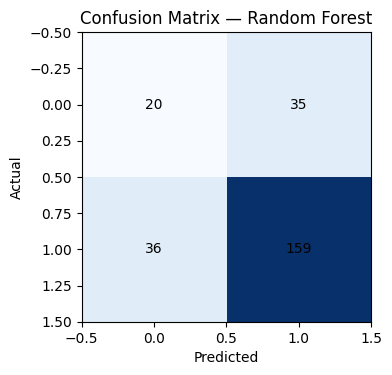

In [155]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix — Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()

# 🔹 Save the figure as PNG before showing
plt.savefig("confusion_matrix_rf.png", dpi=300, bbox_inches="tight")

plt.show()


**Explanation:**  
Visualizes correct vs. incorrect predictions for the main model. Comment on false positives/negatives.

## Step 7 — Feature Importance (Random Forest)

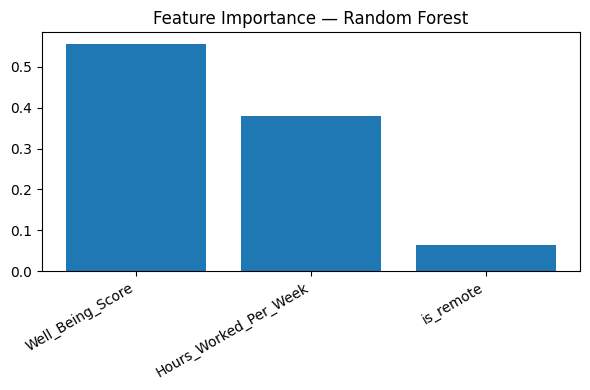

In [156]:
importances = rf.feature_importances_
order = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), [X.columns[i] for i in order], rotation=30, ha='right')
plt.title('Feature Importance — Random Forest')
plt.tight_layout()


# 🔹 Save the figure as PNG before showing
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")

plt.show()

## Step 8 — Digital Twin Simulations (Random Forest)

In [157]:
def predicted_rate(model, X):
    return model.predict(X).mean()

base_rate = predicted_rate(rf, X_test.copy())

# Scenario A: reduce hours by 10%
X_A = X_test.copy()
X_A['Hours_Worked_Per_Week'] = (X_A['Hours_Worked_Per_Week'] * 0.90).clip(lower=10)
rate_A = predicted_rate(rf, X_A)

# Scenario B: increase well-being by +10 points (cap at 100)
X_B = X_test.copy()
X_B['Well_Being_Score'] = np.clip(X_B['Well_Being_Score'] + 10, 0, 100)
rate_B = predicted_rate(rf, X_B)

print(f'Base predicted productive rate: {base_rate:.3f}')
print(f'Scenario A (hours -10%):       {rate_A:.3f}  change={(rate_A - base_rate)*100:+.2f} pp')
print(f'Scenario B (well-being +10):    {rate_B:.3f}  change={(rate_B - base_rate)*100:+.2f} pp')

Base predicted productive rate: 0.776
Scenario A (hours -10%):       0.808  change=+3.20 pp
Scenario B (well-being +10):    0.820  change=+4.40 pp


In [158]:
# Scenario C: Low well-being (<50) & high hours (>45) joint intervention
X_C = X_test.copy()
mask_C = (X_C['Well_Being_Score'] < 50) & (X_C['Hours_Worked_Per_Week'] > 45)

# Baseline for this subgroup
y_true_C = y_test[mask_C]
y_pred_C_base = rf.predict(X_C[mask_C])

baseline_C_acc = accuracy_score(y_true_C, y_pred_C_base)
baseline_C_f1  = f1_score(y_true_C, y_pred_C_base, zero_division=0)

# Intervention: reduce hours by 5%, increase WB by +10 (cap 100)
X_C.loc[mask_C, 'Hours_Worked_Per_Week'] *= 0.95
X_C.loc[mask_C, 'Well_Being_Score'] = np.minimum(100, X_C.loc[mask_C, 'Well_Being_Score'] + 10)

y_pred_C_int = rf.predict(X_C[mask_C])
int_C_acc = accuracy_score(y_true_C, y_pred_C_int)
int_C_f1  = f1_score(y_true_C, y_pred_C_int, zero_division=0)

print("Scenario C (subgroup only)")
print(f"Baseline: Accuracy={baseline_C_acc:.3f}, F1={baseline_C_f1:.3f}")
print(f"Intervention: Accuracy={int_C_acc:.3f}, F1={int_C_f1:.3f}")


# Scenario D: Mode swap for borderline cases (near threshold ±0.05)
proba = rf.predict_proba(X_test)[:, 1]
border_mask = (np.abs(proba - 0.5) <= 0.05)

y_true_D = y_test[border_mask]
y_pred_D_base = (proba[border_mask] >= 0.5).astype(int)

baseline_D_acc = accuracy_score(y_true_D, y_pred_D_base)
baseline_D_f1  = f1_score(y_true_D, y_pred_D_base, zero_division=0)

# Swap remote <-> office
X_D = X_test.copy()
X_D.loc[border_mask, 'is_remote'] = 1 - X_D.loc[border_mask, 'is_remote']
y_pred_D_swap = rf.predict(X_D[border_mask])

int_D_acc = accuracy_score(y_true_D, y_pred_D_swap)
int_D_f1  = f1_score(y_true_D, y_pred_D_swap, zero_division=0)

print("\nScenario D (borderline only)")
print(f"Baseline: Accuracy={baseline_D_acc:.3f}, F1={baseline_D_f1:.3f}")
print(f"Mode Swap: Accuracy={int_D_acc:.3f}, F1={int_D_f1:.3f}")


Scenario C (subgroup only)
Baseline: Accuracy=0.571, F1=0.667
Intervention: Accuracy=0.571, F1=0.727


/tmp/ipython-input-3695978042.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[45.6  50.35 57.95 49.4  44.65 48.45 51.3  48.45 43.7  49.4  45.6  45.6
 52.25 43.7 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_C.loc[mask_C, 'Hours_Worked_Per_Week'] *= 0.95



Scenario D (borderline only)
Baseline: Accuracy=0.474, F1=0.583
Mode Swap: Accuracy=0.632, F1=0.774


## Step 10 — Discussion

The three models show complementary perspectives. Logistic Regression is a linear, interpretable baseline;
Random Forest balances performance and interpretability; Gradient Boosting often provides strong accuracy.
Random Forest is selected for digital-twin simulations due to robustness and feature importance.

Feature importance typically ranks well-being and hours as dominant signals, with remote status smaller.
What-if simulations show percentage-point changes in predicted productive rate when reducing weekly hours by 10%
or increasing well-being by 10 points, supporting evidence-based policy decisions in hybrid work settings.

In [159]:
!jupyter nbconvert --to html 'Digital_Twin_Productivity.ipynb'

[NbConvertApp] WARNING | pattern 'Digital_Twin_Productivity.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]